In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pprint, os, logging, sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO, stream=sys.stdout)
logging.info(f"Start with tf version={tf.version.VERSION}")

2020-09-30 17:28:56,849 | INFO : Start with tf version=2.3.1


In [24]:
# set up paths
nih_cxr8_base = os.path.sep.join(['\\\\KRAMPUS-16', 'DataAll', 'NIH_Cxr8'])
nih_cxr8_csv = os.path.sep.join([nih_cxr8_base, 'Data_Entry_2017_v2020.csv'])
logging.info(f"Reading from {nih_cxr8_csv}")

# read the csv dataset
cxr_batched_ds = tf.data.experimental.make_csv_dataset(
    file_pattern=nih_cxr8_csv, batch_size=3, num_epochs=1, num_parallel_reads=20,
    shuffle=False)

# look at first 50
cxr_batched_ds = cxr_batched_ds.take(50)

# filter for No Finding
nofinding_cxrs = \
    cxr_batched_ds.filter(
        lambda item: tf.equal(item['Finding Labels'][0], 'No Finding'))

# show a few
for batch in nofinding_cxrs.take(3):
    logging.info("-----------")    
    for item in batch:
        logging.info(f"{item}: {batch[item]}") 

2020-09-30 17:41:02,938 | INFO : Reading from \\KRAMPUS-16\DataAll\NIH_Cxr8\Data_Entry_2017_v2020.csv
2020-09-30 17:41:03,043 | INFO : -----------
2020-09-30 17:41:03,044 | INFO : Image Index: [b'00000002_000.png' b'00000003_001.png' b'00000003_002.png']
2020-09-30 17:41:03,045 | INFO : Finding Labels: [b'No Finding' b'Hernia' b'Hernia']
2020-09-30 17:41:03,047 | INFO : Follow-up #: [0 0 1]
2020-09-30 17:41:03,047 | INFO : Patient ID: [2 3 3]
2020-09-30 17:41:03,048 | INFO : Patient Age: [80 74 75]
2020-09-30 17:41:03,049 | INFO : Patient Gender: [b'M' b'F' b'F']
2020-09-30 17:41:03,050 | INFO : View Position: [b'PA' b'PA' b'PA']
2020-09-30 17:41:03,051 | INFO : OriginalImage[Width: [2500 2500 2048]
2020-09-30 17:41:03,052 | INFO : Height]: [2048 2048 2500]
2020-09-30 17:41:03,053 | INFO : OriginalImagePixelSpacing[x: [0.171 0.168 0.168]
2020-09-30 17:41:03,053 | INFO : y]: [0.171 0.168 0.168]
2020-09-30 17:41:03,056 | INFO : -----------
2020-09-30 17:41:03,057 | INFO : Image Index: [b

In [25]:
from skimage.util import img_as_uint
import cv2
clahe = cv2.createCLAHE()

def read_clahe_pixels(fn):
    """ """
    # read and resize image
    pixels = tf.io.decode_png(tf.io.read_file(fn))
    pixels = tf.image.resize(pixels, (128,128))
        
    # whiten image
    img_max, img_min = tf.math.reduce_max(pixels), tf.math.reduce_min(pixels)
    pixels -= img_min
    pixels /= (img_max - img_min)
    
    # filter image
    pixels = tf.py_function(
        lambda pixels_in:clahe.apply(img_as_uint(pixels_in)), 
            [pixels], tf.float32)
    return pixels

def process_batch_pixels(batch_dict):
    """ """
    batch_dict = batch_dict.copy()
    
    # create the image file name
    filename = \
        tf.strings.join([nih_cxr8_base, 'images', batch_dict['Image Index']], 
                        separator=os.path.sep)
    
    # map the read/process function
    batch_dict['Pixels'] = \
        tf.map_fn(read_clahe_pixels, filename, fn_output_signature=tf.float32)
    return batch_dict

nofinding_cxrs_w_pixels = nofinding_cxrs.map(process_batch_pixels)
for batch in nofinding_cxrs_w_pixels:
    logging.info("-----------")
    for item in batch:
        if item == 'Pixels':
            logging.info(f"{item}: {batch[item].shape}")
        else:
            logging.info(f"{item}: {batch[item]}")
    break

2020-09-30 17:41:08,968 | INFO : -----------
2020-09-30 17:41:08,969 | INFO : Image Index: [b'00000002_000.png' b'00000003_001.png' b'00000003_002.png']
2020-09-30 17:41:08,970 | INFO : Finding Labels: [b'No Finding' b'Hernia' b'Hernia']
2020-09-30 17:41:08,971 | INFO : Follow-up #: [0 0 1]
2020-09-30 17:41:08,972 | INFO : Patient ID: [2 3 3]
2020-09-30 17:41:08,973 | INFO : Patient Age: [80 74 75]
2020-09-30 17:41:08,973 | INFO : Patient Gender: [b'M' b'F' b'F']
2020-09-30 17:41:08,974 | INFO : View Position: [b'PA' b'PA' b'PA']
2020-09-30 17:41:08,975 | INFO : OriginalImage[Width: [2500 2500 2048]
2020-09-30 17:41:08,976 | INFO : Height]: [2048 2048 2500]
2020-09-30 17:41:08,976 | INFO : OriginalImagePixelSpacing[x: [0.171 0.168 0.168]
2020-09-30 17:41:08,977 | INFO : y]: [0.171 0.168 0.168]
2020-09-30 17:41:08,978 | INFO : Pixels: (3, 128, 128)


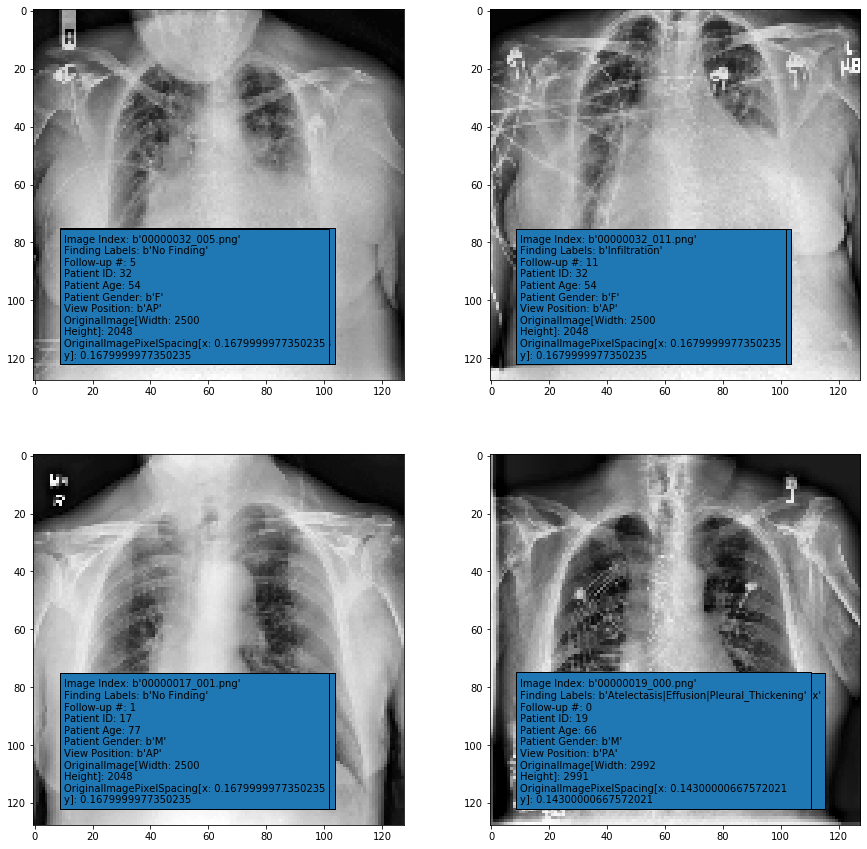

In [31]:
count = 0
show_batch_item = 2
fig,axs = plt.subplots(2,2, figsize=(15,15))
for batch in nofinding_cxrs_w_pixels:
    for_axs = axs[count // 2][count % 2]
    overlay = []
    for item in batch:
        if item == 'Pixels':
            for_axs.imshow(batch[item][show_batch_item,...], cmap='gray')
        else:
            overlay.append(f"{item}: {batch[item][show_batch_item]}")
    for_axs.text(10, 120, "\n".join(overlay), bbox=dict(fill=True))
    count = (count+1) % 4

In [32]:
for batch in nofinding_cxrs_w_pixels:
    print(batch['Pixels'].shape)

(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
(3, 128, 128)
